### RNN with Attention (Possible solution)

In [1]:
# -*- coding: utf-8 -*-
"""
Wind Turbine Power Prediction with RNNs + Attention

This lab uses an Attention-enhanced Recurrent Neural Network to predict wind turbine power output.
"""

# Step 0: Load libraries & Data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Layer
from tensorflow.keras.callbacks import EarlyStopping
import math

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

2025-05-30 18:28:26.678657: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### 1. Data Prep

In [2]:
# Step 1: Prepare the Data
df = pd.read_csv('T1.csv')
df['Date/Time'] = pd.to_datetime(df['Date/Time'], format='%d %m %Y %H:%M')
df.isnull().sum()
# EDA done in Lab 4 for the same data

Date/Time                        0
LV ActivePower (kW)              0
Wind Speed (m/s)                 0
Theoretical_Power_Curve (KWh)    0
Wind Direction (°)               0
dtype: int64

In [3]:
df.isna().sum()

Date/Time                        0
LV ActivePower (kW)              0
Wind Speed (m/s)                 0
Theoretical_Power_Curve (KWh)    0
Wind Direction (°)               0
dtype: int64

In [4]:
# Display basic information
print(df.shape)
df.head()

(50530, 5)


,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
0,2018-01-01 00:00:00,380.047791,5.311336,416.328908,259.994904
1,2018-01-01 00:10:00,453.769196,5.672167,519.917511,268.641113
2,2018-01-01 00:20:00,306.376587,5.216037,390.900016,272.564789
3,2018-01-01 00:30:00,419.645905,5.659674,516.127569,271.258087
4,2018-01-01 00:40:00,380.650696,5.577941,491.702972,265.674286


In [5]:
df.describe()

,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
count,50530,50530.000000,50530.000000,50530.000000,50530.000000
mean,2018-07-01 20:01:30.065307648,1307.684332,7.557952,1492.175463,123.687559
min,2018-01-01 00:00:00,-2.471405,0.000000,0.000000,0.000000
25%,2018-04-03 05:22:30,50.677890,4.201395,161.328167,49.315437
50%,2018-06-30 16:15:00,825.838074,7.104594,1063.776283,73.712978
75%,2018-09-26 18:57:30,2482.507568,10.300020,2964.972462,201.696720
max,2018-12-31 23:50:00,3618.732910,25.206011,3600.000000,359.997589
std,NaN,1312.459242,4.227166,1368.018238,93.443736


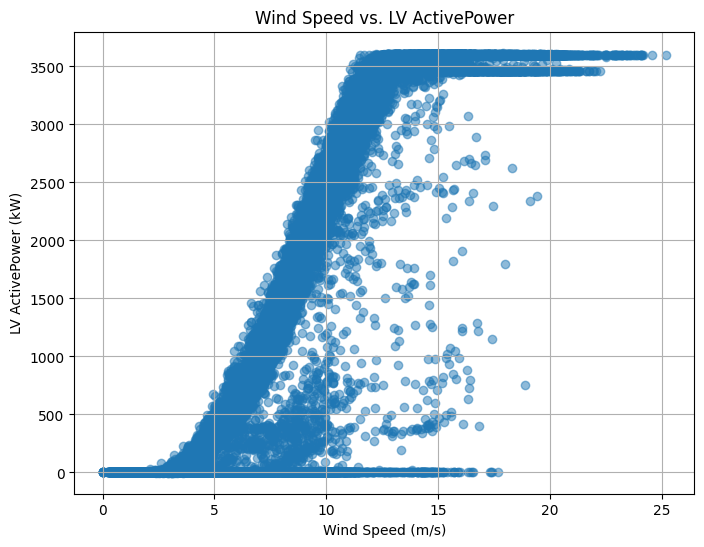

In [6]:
# Scatter plot of Wind Speed vs. LV ActivePower
plt.figure(figsize=(8, 6))
plt.scatter(df['Wind Speed (m/s)'], df['LV ActivePower (kW)'], alpha=0.5)
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('LV ActivePower (kW)')
plt.title('Wind Speed vs. LV ActivePower')
plt.grid(True)
plt.show()

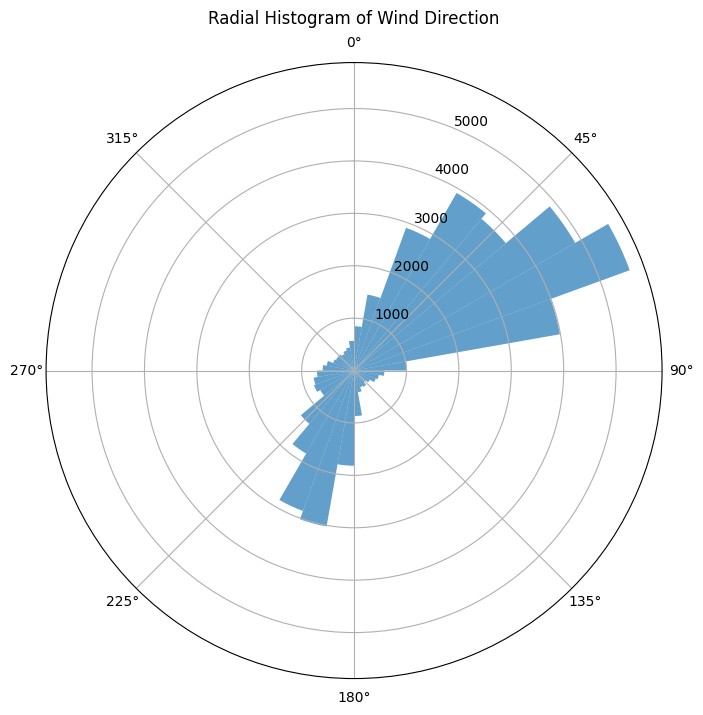

In [7]:
# Convert wind direction to radians
wind_direction_radians = np.deg2rad(df['Wind Direction (°)'])

# Create bins for wind direction (0 to 360 degrees, mapped to radians)
num_bins = 36  # Adjust granularity as needed
hist, bin_edges = np.histogram(wind_direction_radians, bins=num_bins)

# Create a polar histogram
plt.figure(figsize=(8, 8))
ax = plt.subplot(111, projection='polar')
bars = ax.bar(bin_edges[:-1], hist, width=np.diff(bin_edges), align='edge', alpha=0.7)

# Adjust aesthetics
ax.set_theta_zero_location('N')  # Set 0° at the top (north)
ax.set_theta_direction(-1)  # Clockwise orientation
ax.set_title('Radial Histogram of Wind Direction', va='bottom')

plt.show()

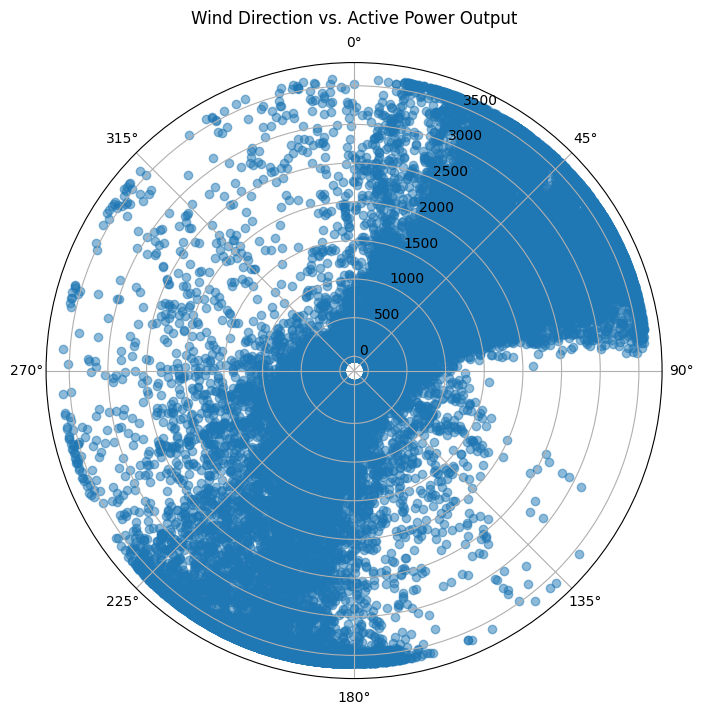

In [8]:
df['Wind Direction (radians)'] = np.deg2rad(df['Wind Direction (°)'])

# Polar scatter plot of Wind Direction vs. Active Power
plt.figure(figsize=(8, 8))
ax = plt.subplot(111, projection='polar')
ax.scatter(df['Wind Direction (radians)'], df['LV ActivePower (kW)'], alpha=0.5)

ax.set_theta_zero_location('N')  # Set 0° at the top (north)
ax.set_theta_direction(-1)  # Clockwise direction

ax.set_title('Wind Direction vs. Active Power Output', va='bottom')
plt.show()

In [9]:
data = df[['Wind Speed (m/s)', 'Theoretical_Power_Curve (KWh)', 'Wind Direction (°)']]
target = df['LV ActivePower (kW)']

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

### 2. Create Sequences

In [10]:
# Step 2: Create sequences
def create_sequences(data, target, seq_length=24):
    X = []
    y = []

    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i])  # Collect sequence window
        y.append(target[i])  # Target is the value right after the window

    X = np.array(X)
    y = np.array(y)

    # Remove?
    # X = np.reshape(X, (X.shape[0], X.shape[1], X.shape[2]))  # Reshape for model input compatibility

    return X, y

X, y = create_sequences(scaled_data, target)

X.shape, y.shape

((50506, 24, 3), (50506,))

### 3. Split the Data

In [11]:
# Step 3: Split the data
train_size = int(len(X) * 0.8)

X_train, X_test = X[:train_size], X[train_size:]

y_train, y_test = y[:train_size], y[train_size:]

X_train.shape, X_test.shape

((40404, 24, 3), (10102, 24, 3))

### 4. Your Attention Layers and Gentlemen, If You Please

In [12]:
# Step 4: Define a Custom Attention Layer
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create trainable weights for computing attention scores
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], input_shape[-1]), initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[-1],), initializer="zeros")
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs):
        # Compute alignment scores using tanh activation
        score = tf.tanh(tf.matmul(inputs, self.W) + self.b)
        # Normalize scores to get attention weights
        attention_weights = tf.nn.softmax(score, axis=1)
        # Compute the context vector as a weighted sum of inputs
        context_vector = attention_weights * inputs
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights


### 5. Build RNN With Attention

In [13]:
# Step 5: Build the RNN Model with Attention

seq_length = 24  # Ensure this matches sequence setup

# Define input layer
input_seq = Input(shape=(seq_length, 3))

# LSTM with return_sequences=True to provide full sequence to attention layer
lstm_out = LSTM(50, return_sequences=True)(input_seq)

# Apply custom attention layer
context_vector, attention_weights = AttentionLayer()(lstm_out)

# Final Dense layer for output
output = Dense(1, activation="linear")(context_vector)

# Create and compile model
model = Model(inputs=input_seq, outputs=output)
model.compile(optimizer="adam", loss="mse")

# EarlyStopping to prevent overfitting
early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

# Print model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 24, 3)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 24, 50)         │        10,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer                 │ [(None, 50), (None,    │         2,550 │
│ (AttentionLayer)                │ 24, 50)]               │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,401 (52.35 KB)

 Trainable params: 13,401 (52.35 KB)

 Non-trainable params: 0 (0.00 B)

### 6. Compile and Train Model

In [14]:
# Step 6: Compile and Train the Model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model.compile(optimizer='adam', loss='mse')
history = model.fit(X, y, epochs=50, batch_size=32, 
                    validation_split=0.2, verbose=1, callbacks=[early_stopping])


Epoch 1/50
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 3244523.7500 - val_loss: 3736890.0000
Epoch 2/50
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 3081573.0000 - val_loss: 3567191.0000
Epoch 3/50
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 2939499.5000 - val_loss: 3408684.5000
Epoch 4/50
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 2807496.7500 - val_loss: 3259377.2500
Epoch 5/50
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 2684239.5000 - val_loss: 3118338.5000
Epoch 6/50
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 2569519.2500 - val_loss: 2985931.5000
Epoch 7/50
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 2461922.7500 - val_loss: 2861050.7500
Epoch 8/50
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 2362361.7500 - val_loss: 2744049.2500
Epoch 9/50
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 2268972.5000 - val_loss: 2585717.5000
Epoch 10/50
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 2116428.2500 - val_loss: 2450720.5000

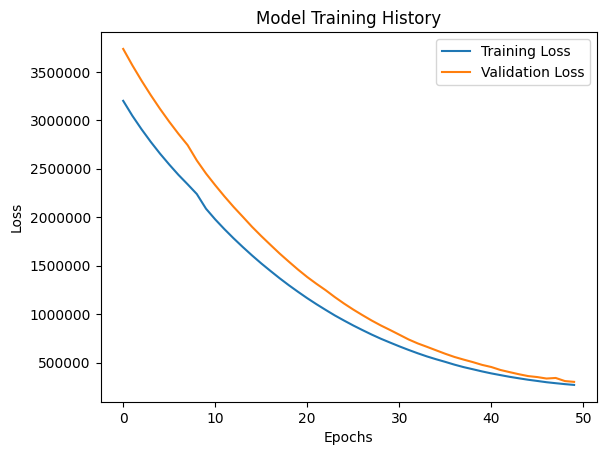

In [15]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Force true numeric labels instead of scientific notation
plt.ticklabel_format(style="plain", axis="y")

plt.legend()
plt.title('Model Training History')
plt.show()

### 7. Evaluate and Visualize Results

In [16]:
test_loss = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss (MSE): {test_loss:.4f}")



316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 204890.3594
Test Loss (MSE): 300410.1562


In [17]:
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}")

316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
MSE: 300410.1597, RMSE: 548.0969, R²: 0.8332


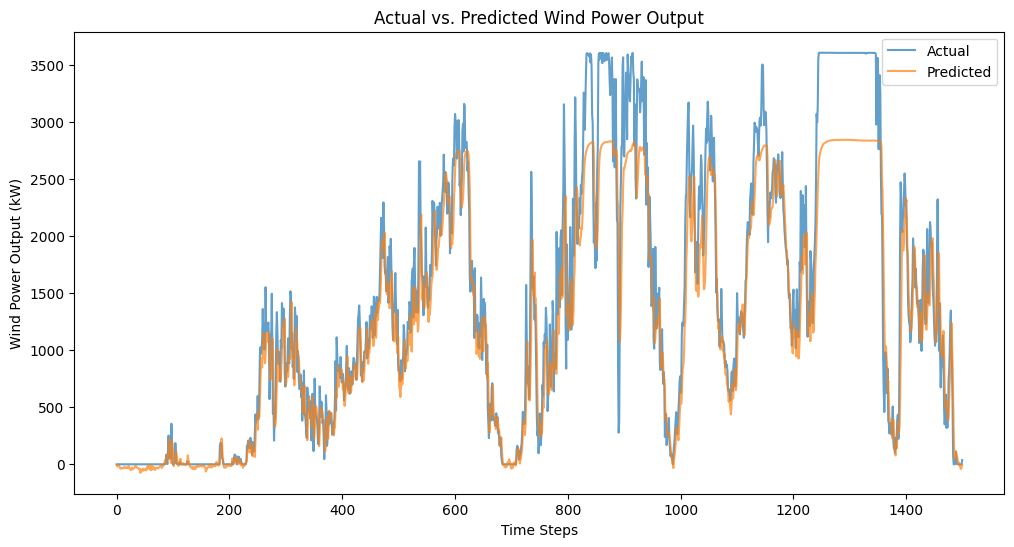

In [18]:
plt.figure(figsize=(12, 6))
plt.plot(y_test[:1500], label="Actual", alpha=0.7)
plt.plot(y_pred[:1500], label="Predicted", alpha=0.7)
plt.xlabel("Time Steps")
plt.ylabel("Wind Power Output (kW)")
plt.legend()
plt.title("Actual vs. Predicted Wind Power Output")
plt.show()
